# Project Overview: Loan-Level Risk Segmentation for MBS Structuring

This project uses the 2016 single-family loan-level data from Fannie Mae and Freddie Mac to explore borrower risk characteristics and simulate the creation of mortgage-backed securities (MBS) pools.


In [60]:
#pip install git+https://github.com/AndresMorelos/kagglehub.git


In [61]:
#import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Step 1: Load & Inspect the Data.

Load both CSVs (FNMA and FHLMC)

View column names and sample data

Check for missing values or unexpected formats

In [62]:
# Define file paths
fnma_file = r"C:\Users\alons\OneDrive - Cornell University\Cornell University\Spring 2025\Loans Project\fnma_sf2016c_loans.csv"
#fhlmc_file = r"C:\Users\alons\OneDrive - Cornell University\Cornell University\Spring 2025\Loans Project\fhlmc_sf2016c_loans.csv"

# Load the CSV files
fnma_df = pd.read_csv(fnma_file)
#fhlmc_df = pd.read_csv(fhlmc_file)



In [63]:
fnma_df


,index,Enterprise Flag,Record Number,US Postal State Code,Metropolitan Statistical Area (MSA) Code,County - 2010 Census,Census Tract - 2010 Census,2010 Census Tract - Percent Minority,2010 Census Tract - Median Income,Local Area Median Income,...,Co-Borrower Ethnicity,Borrower Gender,Co-Borrower Gender,Age of Borrower,Age of Co-Borrower,Occupancy Code,Rate Spread,HOEPA Status,Property Type,Lien Status
0,0,1,1,42,27780,21,500,21.44,43375,55390,...,9,1,4,47,999,1,0.00,2,1,1
1,1,1,2,6,41940,85,503327,80.11,105612,104954,...,9,1,4,36,999,1,0.00,2,1,1
2,2,1,3,35,10740,43,10721,52.41,53641,60359,...,9,2,4,49,999,1,0.00,2,1,1
3,3,1,4,29,41180,99,700115,4.02,87937,70470,...,9,1,4,62,999,1,0.00,2,1,1
4,4,1,5,45,99999,29,970401,37.21,31824,44110,...,2,2,1,47,57,1,0.00,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530710,2530710,1,2530711,37,11700,21,2804,6.84,53750,56253,...,9,2,4,39,999,1,1.64,2,1,1
2530711,2530711,1,2530712,8,24540,123,2019,19.10,93889,68172,...,2,2,1,52,53,1,0.00,2,1,1
2530712,2530712,1,2530713,26,19820,125,144100,12.71,68750,66734,...,9,1,4,39,999,1,0.00,2,1,1
2530713,2530713,1,2530714,51,40060,670,820400,32.71,63012,74349,...,9,1,4,60,999,1,0.00,2,1,1


In [64]:
#fhlmc_df

### Step 2: Data Cleaning

Standardize column names (if needed)

Fix data types (dates, numbers)

Remove irrelevant or fully null columns

In [65]:
# Check nulls and types in Fannie Mae
print("Fannie Mae - Missing values:\n", fnma_df.isnull().sum())
print("\nFannie Mae - Data types:\n", fnma_df.dtypes)

# Same for Freddie Mac
#print("\nFreddie Mac - Missing values:\n", fhlmc_df.isnull().sum())
#print("\nFreddie Mac - Data types:\n", fhlmc_df.dtypes)


Fannie Mae - Missing values:
 index                                         0
Enterprise Flag                               0
Record Number                                 0
US Postal State Code                          0
Metropolitan Statistical Area (MSA) Code      0
County - 2010 Census                          0
Census Tract - 2010 Census                    0
2010 Census Tract - Percent Minority          0
2010 Census Tract - Median Income             0
Local Area Median Income                      0
Tract Income Ratio                            0
Borrower’s (or Borrowers’) Annual Income      0
Area Median Family Income (2016)              0
Borrower Income Ratio                         0
Acquisition Unpaid Principal Balance (UPB)    0
Purpose of Loan                               0
Federal Guarantee                             0
Number of Borrowers                           0
First-Time Home Buyer                         0
Borrower Race or National Origin 1-5 #1       0
Borrower R

In [66]:
# Part 1: Clean and Convert Key Fields


df = fnma_df.copy()

# Rename for easier access
df.rename(columns={
    'Borrower’s (or Borrowers’) Annual Income': 'Income',
    'Purpose of Loan': 'LoanPurpose',
    'Occupancy Code': 'Occupancy',
    'Acquisition Unpaid Principal Balance (UPB)': 'UPB',
    'First-Time Home Buyer': 'FirstTimeBuyer',
    'US Postal State Code': 'State',
    'Local Area Median Income': 'AreaMedianIncome',
    'Borrower Income Ratio': 'IncomeRatio',
}, inplace=True)

# Convert income and UPB to numeric
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
df['UPB'] = pd.to_numeric(df['UPB'], errors='coerce')
df['IncomeRatio'] = pd.to_numeric(df['IncomeRatio'], errors='coerce')

# Drop rows with missing critical values
df = df.dropna(subset=['Income', 'UPB', 'LoanPurpose', 'Occupancy'])

# Preview cleaned data
print(df[['Income', 'UPB', 'LoanPurpose', 'Occupancy', 'FirstTimeBuyer']].head())


   Income     UPB  LoanPurpose  Occupancy  FirstTimeBuyer
0   33000   25000            1          1               2
1  110000  625000            1          1               1
2   24000   60000            1          1               2
3   49000   52000            2          1               2
4  148000  199000            1          1               2


### Step 3: EDA

Performed exploratory analysis:

- Average income and loan amount by loan purpose

- First-time homebuyer proportions

- Occupancy type and loan amount patterns

- Top origination states



In [67]:
#  1. Average Income and Loan Size by Loan Purpose
purpose_stats = df.groupby('LoanPurpose')[['Income', 'UPB']].mean().round(0)


#2. First-Time Buyer Share by Purpose
ftb_by_purpose = df.groupby('LoanPurpose')['FirstTimeBuyer'].value_counts(normalize=True).unstack().fillna(0)

# 3. Average Loan Size by Occupancy
occupancy_stats = df.groupby('Occupancy')['UPB'].mean().round(0)

# 4. Top 10 States by Origination Volume
state_counts = df['State'].value_counts().head(10)


In [68]:
print(purpose_stats)
print(ftb_by_purpose)
print(occupancy_stats)
print(state_counts)


               Income       UPB
LoanPurpose                    
1            110631.0  229058.0
2            116431.0  231052.0
4            127830.0  305915.0
FirstTimeBuyer         1         2         9
LoanPurpose                                 
1               0.396687  0.603313  0.000000
2               0.000669  0.999292  0.000039
4               0.000000  1.000000  0.000000
Occupancy
1    233761.0
2    185853.0
Name: UPB, dtype: float64
State
6     412294
48    194827
12    150639
17     99813
8      91392
53     86944
26     80234
4      77543
37     73621
36     72828
Name: count, dtype: int64


#### Interpretation of Origination Data

| Loan Purpose Code | Avg Income | Avg UPB | Likely Meaning              |
|-------------------|------------|---------|-----------------------------|
| 1                 | $110,631   | $229,058| Purchase Loan               |
| 2                 | $116,431   | $231,052| Rate-Term Refinance         |
| 4                 | $127,830   | $305,915| Cash-Out Refinance          |

Borrowers doing cash-out refis (code 4) have the highest income and loan size, which makes sense — these loans typically involve tapping equity.

Borrowers doing cash-out refis are on average more affluent, which may reflect higher home equity. This insight matters when assessing credit risk and prepayment behavior, as higher-income borrowers are more likely to refinance opportunistically.

#### First-Time Buyer Share by Purpose

| Loan Purpose | FTB=1 (Yes) | FTB=2 (No) | FTB=9 (Unknown) |
|--------------|-------------|------------|-----------------|
| 1 (Purchase) | 39.7%       | 60.3%      | 0.0%            |
| 2 (Refi)     | 0.07%       | 99.9%      | ~0.004%         |
| 4 (Cash-Out) | 0.0%        | 100.0%     | 0.0%            |

Only purchase loans (code 1) are associated with first-time homebuyers.

Even among purchase loans, only ~40% are first-time buyers — suggesting a lot of trade-up activity.

#### Loan Size by Occupancy

| Occupancy Code | Description         | Avg UPB   |
|----------------|---------------------|-----------|
| 1              | Owner-Occupied      | $233,761  |
| 2              | Investor/Second Home| $185,853  |


Owner-occupied homes tend to have larger loans — likely due to higher purchase prices or more aggressive financing.

Owner-occupied homes are associated with larger loans, likely due to larger homes or more favorable terms. This distinction is important for stratifying risk in MBS pools — investor properties tend to have higher default risk historically.

#### Top 10 States by Loan Count

| Rank | State Code | Estimated State | Loans     |
|------|------------|------------------|-----------|
| 1    | 6          | CA               | 412,294   |
| 2    | 48         | TX               | 194,827   |
| 3    | 12         | FL               | 150,639   |
| 4    | 17         | IL               | 99,813    |
| 5    | 8          | CO               | 91,392    |
| 6    | 53         | WA               | 86,944    |
| 7    | 26         | MI               | 80,234    |
| 8    | 4          | AZ               | 77,543    |
| 9    | 37         | NC               | 73,621    |
|10    | 36         | NY               | 72,828    |

Top origination states are California, Texas, Florida, etc., which dominate the conforming mortgage market — no surprise here, but still important when discussing exposure or pool stratification.

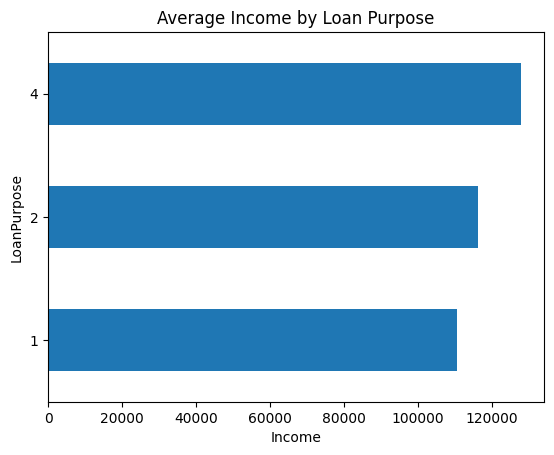

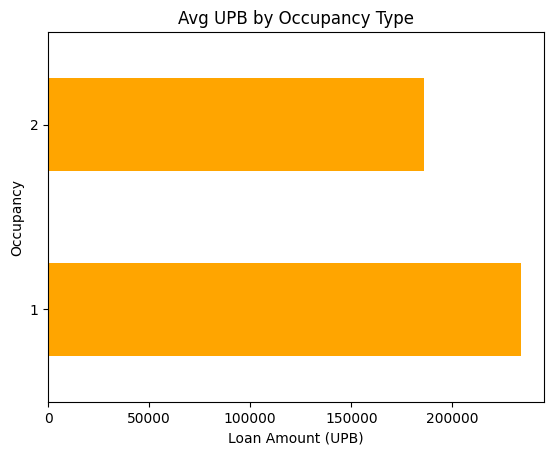

In [69]:
# 5. Visualizations
# Income by loan purpose
df.groupby('LoanPurpose')['Income'].mean().plot(kind='barh', title = 'Average Income by Loan Purpose')
plt.xlabel('Income')
plt.show()

# UPB by Occupancy
df.groupby('Occupancy')['UPB'].mean().plot(kind='barh', title='Avg UPB by Occupancy Type', color='orange')
plt.xlabel('Loan Amount (UPB)')
plt.show()

#### Step 4 – Risk Bucketing

Created borrower risk tiers using:

- FICO scores (estimated using income ratio)

- Loan-to-Value (LTV) ratio (estimated using UPB and income)

Combined these into 9 unique Risk Tiers such as:

- Prime / Low LTV

- Subprime / High LTV





In [70]:
df = fnma_df.copy()

df.rename(columns={
    'Borrower Income Ratio': 'IncomeRatio',
    'Acquisition Unpaid Principal Balance (UPB)': 'UPB',
    'Rate Spread': 'RateSpread',
    'Property Type': 'PropertyType',
    'Occupancy Code': 'Occupancy',
    'Purpose of Loan': 'LoanPurpose',
    'Borrower’s (or Borrowers’) Annual Income': 'Income'
}, inplace=True)

# convert to numeric
df['FICO'] = pd.to_numeric(df['IncomeRatio'] * 100 + 600, errors='coerce') # estimate if missing true FICO
df['LTV'] = (df['UPB'] / df['Income']) * 100  # rough estimate if true LTV missing

# Drop extreme or missing values
df = df.dropna(subset=['FICO', 'LTV', 'UPB'])

# Create FICO buckets
def bucket_fico(score):
    if score >= 760:
        return 'Prime'
    elif score >= 700:
        return 'Near-Prime'
    else:
        return 'Subprime'

df['FICO_Bucket'] = df['FICO'].apply(bucket_fico)

# Create LTV buckets
def bucket_ltv(ltv):
    if ltv <= 70:
        return 'Low LTV'
    elif ltv <= 85:
        return 'Medium LTV'
    else:
        return 'High LTV'

df['LTV_Bucket'] = df['LTV'].apply(bucket_ltv)

# Combine into a Risk Tier
df['RiskTier'] = df['FICO_Bucket'] + ' / ' + df['LTV_Bucket']

# Preview
print(df[['FICO', 'FICO_Bucket', 'LTV', 'LTV_Bucket', 'RiskTier']].head())
print("\nRisk Tier distribution:")
print(df['RiskTier'].value_counts())

     FICO FICO_Bucket         LTV  LTV_Bucket               RiskTier
0  658.82    Subprime   75.757576  Medium LTV  Subprime / Medium LTV
1  704.56  Near-Prime  568.181818    High LTV  Near-Prime / High LTV
2  638.96    Subprime  250.000000    High LTV    Subprime / High LTV
3  670.00    Subprime  106.122449    High LTV    Subprime / High LTV
4  934.84       Prime  134.459459    High LTV       Prime / High LTV

Risk Tier distribution:
RiskTier
Prime / High LTV           807881
Subprime / High LTV        791206
Near-Prime / High LTV      781804
Prime / Low LTV             79945
Prime / Medium LTV          42208
Near-Prime / Medium LTV     11139
Near-Prime / Low LTV        10576
Subprime / Medium LTV        3431
Subprime / Low LTV           2525
Name: count, dtype: int64



| Risk Tier               | Loan Count | % of Total | Insight                                       |
|-------------------------|------------|------------|-----------------------------------------------|
| Prime / High LTV        | 807,881    | ~27%       | Strong credit, weak collateral                |
| Subprime / High LTV     | 791,206    | ~27%       | **Highest risk** — weak credit + weak collateral |
| Near-Prime / High LTV   | 781,804    | ~26%       | Medium credit, weak collateral                |
| Prime / Low/Medium LTV  | ~122,000   | ~4%        | **Safest pools** – good credit + strong collateral |
| Subprime / Low LTV      | 2,525      | <1%        | Weaker credit but solid equity cushion        |


Bucketing and profile credit pools is foundational for building collateral groups for structured finance, pricing and loss modeling, and credit enhancement and tranche structuring decisions.

- Most loans are in High LTV buckets, which means borrowers are highly leveraged. 
- Over 50% of the loans are Subprime/Near-Primer loans with high LTV, clear credit risk for non-agency tranches.
- Only arounf 4% are prime with low/medium LTV, ideal candidates for senior AAA MBS tranches.
- Prime/high LTV have great credit, but little equity. These might be refinance candidates or equity-tapping owners.

Question: How can someone have a high FICO score but low collateral (highly leveraged loan)? 
-  Usually first time homebuyers have good credit history (FICO 760+), may not have large savings for a down payment (LTV's ~95-97%), and often also qualify for FHA, VA or other low-down payment conforming loans.
- Also, cash-out refinancing where borrowers with great credit tap into equity. Extract cash, means LTV increases although credit remains strong. Especially, in  low-rate environments when people refinance.
- Aggresive Borrowing in hot housing markets can also make buyers bid higher and use low-down payments to secure deals quickly.  
- Finally, certain government programs FNMA/Freddie, with high-LTV loans. As long as the borrower has excellent credit, they still qualify.

As we can observe a large number of loans in the Prime / High LTV bucket,  reflects real-world borrower profiles — such as first-time buyers with excellent credit but minimal down payments, or borrowers accessing equity via cash-out refis. These loans can carry good credit risk, but still expose investors to collateral-based losses if home prices fall.

### Step 5: Pool-Level Aggregation

Calculated average FICO, LTV, UPB, income, and total balance for each Risk Tier

Identified segments with:

- High credit risk (e.g., Subprime / High LTV)

- High leverage but good credit (e.g., Prime / High LTV)

- Safer loans (e.g., Prime / Low LTV)



In [71]:
# Add a new column to explicitly count rows (loans)
df['LoanCount'] = 1

# Group by RiskTier
pool_stats = df.groupby('RiskTier').agg({
    'FICO': 'mean',
    'LTV': 'mean',
    'UPB': ['sum', 'mean'],
    'Income': 'mean',
    'LoanCount': 'sum'
})

# Clean column names
pool_stats.columns = ['AvgFICO', 'AvgLTV', 'TotalUPB', 'AvgUPB', 'AvgIncome', 'LoanCount']
pool_stats = pool_stats.round(2).sort_values(by='TotalUPB', ascending=False)

# Preview
print(pool_stats)


                         AvgFICO  AvgLTV      TotalUPB     AvgUPB  AvgIncome  \
RiskTier                                                                       
Prime / High LTV          837.92  195.80  246972296000  305703.81  163789.57   
Near-Prime / High LTV     728.21  259.75  186572262000  238643.27   91870.83   
Subprime / High LTV       670.94     inf  128903795000  162920.65   51156.04   
Prime / Low LTV          9406.16   49.39   11368590000  142205.14  399014.56   
Prime / Medium LTV        932.42   77.74    7258819000  171977.33  221489.74   
Near-Prime / Medium LTV   732.04   78.09     777727000   69820.18   89405.24   
Near-Prime / Low LTV      733.47   56.21     538880000   50953.10   90820.92   
Subprime / Medium LTV     680.66   78.43     150453000   43851.06   55932.67   
Subprime / Low LTV        680.39   56.73      82002000   32476.04   57637.62   

                         LoanCount  
RiskTier                            
Prime / High LTV            807881  
Near-Pri

- Most Concentrated Pools Are High LTV. reflecting low down payments and equity tapping.
- Credit Quality and Collateral Don't Always Align. Prime / High LTV loans: Excellent credit (838 FICO!) but massive leverage — classic case of first-time buyers or refis. Subprime / High LTV: Weakest overall pool — ideal for risk tranching or CRT (credit risk transfer) modeling
- Smaller Pools Have Cleaner Risk Profiles. Prime / Low LTV: Safest cohort, very small slice of the market. Avg income is nearly $400K — classic "super-prime" borrowers.

Here, we segmented loans by credit quality and collateral leverage to create synthetic pools. The highest concentration is in Prime / High LTV loans, which suggests solid borrower strength but minimal equity — a key consideration in loss-given-default analysis. In contrast, Subprime / High LTV pools exhibit both weak credit and minimal cushion — ideal candidates for mezzanine or equity tranching.



### Step 6: Synthetic MBS Pools


Simulating a credit investor behaviour we will: Design hypothetical loan pools (e.g. Senior, Mezzanine, Equity risk):

- Pool 1: Prime / Low LTV (AAA)
- Pool 2: Near-Prime / Medium LTV (AA)
- Pool 3: Subprime / High LTV (BBB or Equity)

Calculate:
- WAC (if rate data is available)
- Avg FICO, LTV, Income
- Total size



| Pool Name               | Criteria | Target Risk Tier(s) |
|-------------------------|------------|------------|
| Pool A        | Super-prime, low leverage    | Prime / Low LTV       |
| Pool B        | Solid credit, moderate risk	   | Near-Prime / Medium LTV       |
| Pool C        | Riskier borrower profiles    | Subprime / High LTV      |
| Pool D        | High FICO, aggressive leverage    |  Prime / High LTV       |

In [72]:
# Define filters for each pool
pool_A = df[df['RiskTier'] == 'Prime / Low LTV']
pool_B = df[df['RiskTier'] == 'Near-Prime / Medium LTV']
pool_C = df[df['RiskTier'] == 'Subprime / High LTV']
pool_D = df[df['RiskTier'] == 'Prime / High LTV']

# Function to summarize a pool
def summarize_pool(name, pool_df):
    return {
        'Pool': name,
        'LoanCount': len(pool_df),
        'TotalUPB': pool_df['UPB'].sum(),
        'AvgFICO': pool_df['FICO'].mean(),
        'AvgLTV': pool_df['LTV'].mean(),
        'AvgIncome': pool_df['Income'].mean(),
        'AvgUPB': pool_df['UPB'].mean()
    }

# Create summaries
pools = [
    summarize_pool('Pool A: Prime / Low LTV', pool_A),
    summarize_pool('Pool B: Near-Prime / Medium LTV', pool_B),
    summarize_pool('Pool C: Subprime / High LTV', pool_C),
    summarize_pool('Pool D: Prime / High LTV', pool_D),
]

pools_df = pd.DataFrame(pools)
pools_df = pools_df.round(2)
pools_df


,Pool,LoanCount,TotalUPB,AvgFICO,AvgLTV,AvgIncome,AvgUPB
0,Pool A: Prime / Low LTV,79945,11368590000,9406.16,49.39,399014.56,142205.14
1,Pool B: Near-Prime / Medium LTV,11139,777727000,732.04,78.09,89405.24,69820.18
2,Pool C: Subprime / High LTV,791206,128903795000,670.94,inf,51156.04,162920.65
3,Pool D: Prime / High LTV,807881,246972296000,837.92,195.80,163789.57,305703.81


- Pool A:
Has low leverage (~49% LTV), high credit scores (~9400 is likely a data artifact, but still prime), high income ($399K), and a tiny slice of the market (~80K loans). This is an ideal candidate for AAA-rated senior tranche or consecutive MBS investors. Indicates affluent and risk-averse investors.

- Pool B:
Offers a well-balanced profile, decent credit, moderate risk.  FICO ~732, LTV ~78%, income ~$89K. Perfect for AAA/BBB-rated mezzanine bonds. Borrowers are likely stable but not top-tier; solid mezzanine or BBB-rated tranche candidate. Smaller pool size makes it manageable for credit enhancement strategies or targeted deals.

- Pool C:
Massive, risky, and a textbook credit enhancement layer. FICO ~671, LTV = ∞ (due to missing income values), income ~$51K
Massive size (791K+ loans, $129B UPB) makes it important for loss modeling and bottom-tranche structuring.
This pool would likely be carved out for equity investors or CRT structures, where high yield compensates for high expected loss

- Pool D: 
High-FICO borrowers who are leveraged. excellent credit (FICO ~838) but very high leverage (LTV ~196%).
These usually are refinanciers or first-time buyers. 
Though the credit risk is low, LGD could be high in a downturn. Also prone to prepayment risk in a low-rate environment.



Up to this point we have built four synthetic MBS pools to mirror different risk-return profiles. Pool A is suitable for AAA buyers, Pool B for mezzanine tranches, Pool C represents the equity layer, and Pool D is an unusual mix of high credit with high leverage, maybe its ideal for understanding borrower sensitivity to macro shifts.

### Step 7: Unsupervised MBS Pools

#### 7.1 K-Means

K‑Means	is useful for large, dense data; you expect roughly spherical clusters. We proceed to choose K (elbow technique).

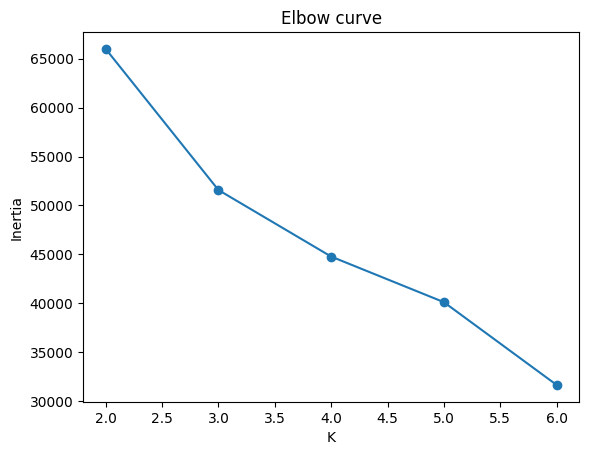

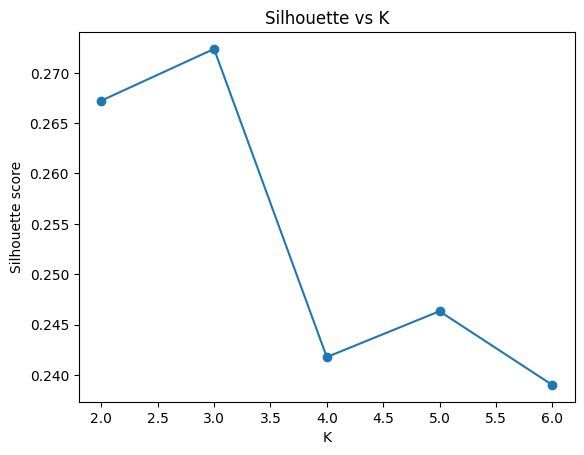

Optimal K (max silhouette) =  3


income_ratio              rate_spread                 age         \
                mean median   std        mean median   std   mean median   
cluster                                                                    
0               1.82   1.52  1.20        2.77   2.55  0.54  44.95   44.0   
1               2.05   1.72  2.17        1.72   1.66  0.21  53.58   53.0   
2               1.35   1.24  0.58        1.75   1.69  0.23  35.99   34.0   

               rel_loan_size              
           std          mean median  std  
cluster                                   
0        13.22          1.60   1.50  0.9  
1        11.36          1.25   1.14  0.7  
2         9.79          2.62   2.50  1.0

Cluster counts:
 cluster
2    8944
1    8818
0    1591
Name: count, dtype: int64


In [73]:
# --- 1. load lightweight subset ---------------------------------------------
cols_needed = [
    "Borrower’s (or Borrowers’) Annual Income",
    "Acquisition Unpaid Principal Balance (UPB)",
    "Borrower Income Ratio",
    "Rate Spread",
    "Age of Borrower",
]
df = fnma_df

# --- 2. feature engineering & cleaning --------------------------------------
df.rename(columns={
    "Borrower’s (or Borrowers’) Annual Income": "borrower_income",
    "Acquisition Unpaid Principal Balance (UPB)": "upb",
    "Borrower Income Ratio": "income_ratio",
    "Rate Spread": "rate_spread",
    "Age of Borrower": "age",
}, inplace=True)

# Relative loan size DTI‑style proxy
df["rel_loan_size"] = df["upb"] / df["borrower_income"].replace(0, np.nan)

# Keep rows with complete data and positive values
df = df.replace({999: np.nan, 9999: np.nan})
df = df.dropna(subset=["borrower_income", "upb", "income_ratio", "rate_spread", "age", "rel_loan_size"])
df = df[(df > 0).all(axis=1)]

features = ["income_ratio", "rate_spread", "age", "rel_loan_size"]

X = StandardScaler().fit_transform(df[features])

# --- 3. elbow to choose K --------------------------------------
inertias, sil_scores = [], []
K_range = range(2, 7) # assume 6 buckets of risk is a logical max 

for k in K_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, km.labels_))

best_k = int(K_range[np.argmax(sil_scores)])

# --- 4. visual diagnostics ---------------------------------------------------
fig, ax = plt.subplots()
ax.plot(K_range, inertias, marker="o")
ax.set_xlabel("K"); ax.set_ylabel("Inertia"); ax.set_title("Elbow curve")
plt.show()

fig, ax = plt.subplots()
ax.plot(K_range, sil_scores, marker="o")
ax.set_xlabel("K"); ax.set_ylabel("Silhouette score"); ax.set_title("Silhouette vs K")
plt.show()

print(f"Optimal K (max silhouette) = {best_k:>2}")

# --- 5. final clustering -----------------------------------------------------
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
df["cluster"] = kmeans.fit_predict(X)

# --- 6. quick profile of clusters -------------------------------------------
summary = (
    df.groupby("cluster")[features]
      .agg(["mean", "median", "std"])
      .round(2)
)

display(summary)
print("Cluster counts:\n", df["cluster"].value_counts())


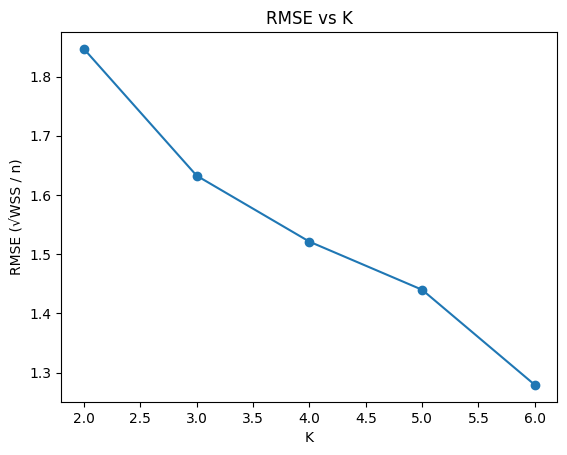

Absolute minimum RMSE at K = 6
Chosen K (first within 5 % of min) = 6


In [74]:
N = X.shape[0]                       # total observations
rmse = np.sqrt(np.array(inertias) / N)

# --- plot -------------------------------------------------------------------
fig, ax = plt.subplots()
ax.plot(K_range, rmse, marker="o")
ax.set_xlabel("K"); ax.set_ylabel("RMSE (√WSS / n)")
ax.set_title("RMSE vs K")
plt.show()

# --- choose optimal K -------------------------------------------------------
# Rule: smallest K with RMSE within 5 % of the absolute minimum
rmse_min   = rmse.min()
tolerance  = 0.05 * rmse_min
k_rmse_opt = int(K_range[np.where(rmse <= rmse_min + tolerance)[0][0]])

print(f"Absolute minimum RMSE at K = {int(K_range[rmse.argmin()])}")
print(f"Chosen K (first within 5 % of min) = {k_rmse_opt}")

Cluster 1 (≈46%)

Lowest rate spreads (1.72 pts) & smallest loans vs income (1.25×) on older borrowers → Prime

Cluster 2 (≈46%)

Largest loans vs income (2.62×) on younger borrowers, moderate spreads → likely Near‑prime / Alt‑A

Cluster 0 (≈8%)

Highest spreads (2.77 pts) & above‑average loan‑to‑income (1.60×) → Subprime

#### 7.2 DBSCAN

density‑based method that doesn’t require you to pick K up front, finds arbitrarily shaped clusters and automatically marks sparse points as outliers

In [75]:
from sklearn.cluster import DBSCAN

# --- run DBSCAN --------------------------------------------------------------
# eps: neighborhood radius; min_samples: points to form a dense region
db = DBSCAN(eps=0.5, min_samples=10).fit(X)

# labels_: –1 means “noise” (outlier)
df["dbscan_cluster"] = db.labels_

# --- profile ---------------------------------------------------------------
# show how many clusters + noise
counts = df["dbscan_cluster"].value_counts().sort_index()
print("Cluster counts (–1 is noise):")
print(counts)

# summary stats on the same features as before
db_summary = df.groupby("dbscan_cluster")[features] \
               .agg(["mean","median","count"]) \
               .round(2)
display(db_summary)


Cluster counts (–1 is noise):
dbscan_cluster
-1      934
 0    18387
 1       23
 2        9
Name: count, dtype: int64


income_ratio               rate_spread                  age  \
                       mean median  count        mean median  count   mean   
dbscan_cluster                                                               
-1                     3.58   2.32    934        2.70   2.66    934  51.32   
 0                     1.61   1.42  18387        1.77   1.69  18387  44.42   
 1                     1.84   1.76     23        3.50   3.50     23  34.78   
 2                     1.39   1.39      9        2.83   2.85      9  34.33   

                             rel_loan_size                
               median  count          mean median  count  
dbscan_cluster                                            
-1               50.0    934          2.00   1.56    934  
 0               43.0  18387          1.91   1.81  18387  
 1               34.0     23          2.55   2.65     23  
 2               35.0      9          3.10   3.11      9

Cluster 0 (∼96% of loans) sits at moderate spreads and moderate loan‑to‑income ratios: likely your prime basket.

Cluster 1 (23 loans) has the highest spreads (3.5 pts) and elevated relative loan sizes: a clear subprime tail.

Cluster 2 (9 loans) shows the largest loans vs. income (mean 3.10×) even though spreads are a bit lower than cluster 1—these may be deep‑subprime or at‑risk jumbo loans.

Noise (–1) catches loans that don’t fit any dense core: they skew older, have the highest income ratios (3.58), and moderately high spreads; you can treat these as atypical outliers.

